In [159]:
# Import library
import os
os.environ["HADOOP_HOME"] = "C:\\hadoop"
os.environ["PATH"] += ";C:\\hadoop\\bin"

print("HADOOP_HOME =", os.environ.get("HADOOP_HOME"))

# Tes winutils path
os.system("where winutils")
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import pandas as pd


# Inisialisasi SparkSession
spark = SparkSession.builder \
    .appName("Midterm Project") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

spark


HADOOP_HOME = C:\hadoop


In [ ]:
# Load preprocessed data
data_path = "../data/processed/processed_medical_cost.parquet"
df_preprocessed = spark.read.parquet(data_path)
df_preprocessed.select("features", "annual_medical_cost").show(5)

+--------------------+-------------------+
|            features|annual_medical_cost|
+--------------------+-------------------+
|(79,[0,1,2,3,5,6,...|            5476.92|
|(79,[0,1,2,3,5,6,...|             844.27|
|(79,[0,1,2,3,5,9,...|            6447.35|
|(79,[0,1,2,3,5,6,...|            1632.74|
|(79,[0,1,2,3,5,6,...|            1621.12|
+--------------------+-------------------+
only showing top 5 rows


In [161]:
# Data dibagi menjadi data pelatihan (80%) dan data pengujian (20%) secara acak
train_df, test_df = df_preprocessed.randomSplit([0.8, 0.2], seed=42)
print(f"Train count: {train_df.count()}, Test count: {test_df.count()}")

Train count: 80109, Test count: 19891


In [162]:
evaluator = RegressionEvaluator(labelCol="annual_medical_cost", predictionCol="prediction")

In [163]:
# Model: Linear Regression

# Inisialisasi model Linear Regression
lr = LinearRegression(featuresCol="features", labelCol="annual_medical_cost")
lr_model = lr.fit(train_df)
lr_predictions = lr_model.transform(test_df)

# Evaluasi performa
mae_lr = evaluator.setMetricName("mae").evaluate(lr_predictions)
rmse_lr = evaluator.setMetricName("rmse").evaluate(lr_predictions)
r2_lr = evaluator.setMetricName("r2").evaluate(lr_predictions)

print(f"Linear Regression -> MAE: {mae_lr:.2f}, RMSE: {rmse_lr:.2f}, R2: {r2_lr:.3f}")

Linear Regression -> MAE: 312.94, RMSE: 559.02, R2: 0.966


In [164]:
# Cek apakah Spark hidup lagi atau masih dihidup
spark.sparkContext

<SparkContext master=local[*] appName=Midterm Project>

Linear Regression hanya punya sedikit hyperparameter (misalnya regParam, elasticNetParam), dan tuning-nya tidak terlalu berpengaruh besar untuk dataset yang besar & kompleks. Namun, dataset yang digunakan tidak besar, maka tidak ada salahnya mencoba tuning hyperparameter model Linear Regression untuk sekedar melihat perbandingannya.

In [165]:
# Hyperparameter Tuning (Linear Regression)
# Mencoba beberapa kombinasi regParam dan elasticNetParam untuk melihat apakah performa bisa ditingkatkan.

# Inisialisasi model Linear Regression
lr = LinearRegression(featuresCol="features", labelCol="annual_medical_cost")

# Tuning regParam dan elasticNetParam
paramGrid_lr = (ParamGridBuilder()
    .addGrid(lr.regParam, [0.0, 0.01, 0.1])
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
    .build())

crossval_lr = CrossValidator(
    estimator=lr,
    estimatorParamMaps=paramGrid_lr,
    evaluator=RegressionEvaluator(labelCol="annual_medical_cost", metricName="rmse"),
    numFolds=3
)

# Latih model dengan cross validation
cv_lr_model = crossval_lr.fit(train_df)

# Ambil model terbaik dan prediksi
best_lr_model = cv_lr_model.bestModel
best_lr_predictions = best_lr_model.transform(test_df)

# Evaluasi performa
mae_lr = evaluator.setMetricName("mae").evaluate(best_lr_predictions)
rmse_lr = evaluator.setMetricName("rmse").evaluate(best_lr_predictions)
r2_lr = evaluator.setMetricName("r2").evaluate(best_lr_predictions)

print(f"Linear Regression (tuned) -> MAE: {mae_lr:.2f}, RMSE: {rmse_lr:.2f}, R²: {r2_lr:.3f}")


Linear Regression (tuned) -> MAE: 312.88, RMSE: 559.01, R²: 0.966


In [166]:
# Cek apakah Spark hidup lagi atau masih dihidup
spark.sparkContext

<SparkContext master=local[*] appName=Midterm Project>

In [167]:
# Model: Random Forest

# Inisialisasi model Random Forest
# rf = RandomForestRegressor(featuresCol="features", labelCol="annual_medical_cost", numTrees=50, maxDepth=10)
# rf = RandomForestRegressor(featuresCol="features", labelCol="annual_medical_cost", numTrees=100, maxDepth=20)
rf = RandomForestRegressor(featuresCol="features", labelCol="annual_medical_cost", numTrees=100, maxDepth=10, seed=42)
rf_model = rf.fit(train_df)
rf_predictions = rf_model.transform(test_df)

# Evaluasi performa
mae_rf = evaluator.setMetricName("mae").evaluate(rf_predictions)
rmse_rf = evaluator.setMetricName("rmse").evaluate(rf_predictions)
r2_rf = evaluator.setMetricName("r2").evaluate(rf_predictions)

print(f"Random Forest -> MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}, R2: {r2_rf:.3f}")

Random Forest -> MAE: 292.09, RMSE: 827.27, R2: 0.925


In [168]:
# Cek apakah Spark hidup lagi atau masih dihidup
spark.sparkContext

<SparkContext master=local[*] appName=Midterm Project>

Random Forest memiliki beberapa hyperparameter penting yang sangat memengaruhi kinerja model, baik dari sisi akurasi maupun kompleksitas model.

| Hyperparameter          | Fungsi                                  | Dampak Jika Tidak Diatur                                                                                        |
| ----------------------- | --------------------------------------- | --------------------------------------------------------------------------------------------------------------- |
| `numTrees`              | Jumlah pohon dalam ensemble             | Terlalu sedikit → underfitting; terlalu banyak → waktu training lama tanpa banyak peningkatan akurasi           |
| `maxDepth`              | Kedalaman maksimum tiap pohon           | Terlalu dangkal → tidak menangkap pola kompleks; terlalu dalam → overfitting                                    |
| `maxBins`               | Jumlah bin untuk fitur numerik          | Mempengaruhi presisi pemisahan; terlalu kecil bisa membuat model kehilangan variasi                             |
| `featureSubsetStrategy` | Proporsi fitur yang digunakan per pohon | Mengontrol diversitas antar pohon; terlalu sedikit → kehilangan informasi; terlalu banyak → pohon terlalu mirip |

Karena Random Forest bersifat non-deterministik (setiap pohon acak), parameter tuning membantu memastikan hasil yang konsisten dan optimal di berbagai subset data.

In [169]:
# Hyperparameter Tuning (Random Forest)
# Menggunakan CrossValidator untuk mencari kombinasi parameter terbaik pada model Random Forest.

# Inisialisasi model Random Forest
rf = RandomForestRegressor(featuresCol="features", labelCol="annual_medical_cost")

# Tuning numTrees dan maxDepth
paramGrid_rf = (ParamGridBuilder()
    .addGrid(rf.numTrees, [50, 100])
    .addGrid(rf.maxDepth, [5, 10, 15])
    .build())

crossval_rf = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid_rf,
    evaluator=RegressionEvaluator(labelCol="annual_medical_cost", metricName="rmse"),
    numFolds=3
)

# Latih model dengan cross validation
cv_rf_model = crossval_rf.fit(train_df)

# Ambil model terbaik dan prediksi
best_rf_model = cv_rf_model.bestModel
best_rf_predictions = best_rf_model.transform(test_df)

# Evaluasi performa
mae_rf = evaluator.setMetricName("mae").evaluate(best_rf_predictions)
rmse_rf = evaluator.setMetricName("rmse").evaluate(best_rf_predictions)
r2_rf = evaluator.setMetricName("r2").evaluate(best_rf_predictions)
print(f"Random Forest (tuned) -> MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}, R²: {r2_rf:.3f}")

Random Forest (tuned) -> MAE: 203.08, RMSE: 762.64, R²: 0.936


In [170]:
# Cek apakah Spark hidup lagi atau masih dihidup
spark.sparkContext

<SparkContext master=local[*] appName=Midterm Project>

In [171]:
# Model: Gradient Boosted Trees

# Inisialisasi model GBT
gbt = GBTRegressor(featuresCol="features", labelCol="annual_medical_cost", maxIter=50, maxDepth=5, stepSize=0.1, seed=42)
# gbt = GBTRegressor(featuresCol="features", labelCol="annual_medical_cost", maxIter=50)
gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)

# Evaluasi performa
mae_gbt = evaluator.setMetricName("mae").evaluate(gbt_predictions)
rmse_gbt = evaluator.setMetricName("rmse").evaluate(gbt_predictions)
r2_gbt = evaluator.setMetricName("r2").evaluate(gbt_predictions)

print(f"GBT Regressor -> MAE: {mae_gbt:.2f}, RMSE: {rmse_gbt:.2f}, R2: {r2_gbt:.3f}")

GBT Regressor -> MAE: 188.08, RMSE: 843.83, R2: 0.922


In [172]:
# Cek apakah Spark hidup lagi atau masih dihidup
spark.sparkContext

<SparkContext master=local[*] appName=Midterm Project>

GBT Regressor (Gradient Boosted Trees) memiliki training time yang jauh lebih lama saat di-tuning, terutama karena boosting bersifat sequential (setiap pohon tergantung pada hasil pohon sebelumnya).

In [ ]:
# Hyper Parameter Tuning (Gradient Boosted Trees)
# Menggunakan CrossValidator untuk mencari kombinasi parameter terbaik pada model GBT.

# Inisialisasi model GBT
gbt = GBTRegressor(featuresCol="features", labelCol="annual_medical_cost", seed=42)

# Buat grid parameter untuk tuning
# Tuning maxDepth, maxIter, dan stepSize
paramGrid_gbt = (ParamGridBuilder()
    .addGrid(gbt.maxDepth, [3, 5, 7])
    .addGrid(gbt.maxIter, [50, 100])
    .addGrid(gbt.stepSize, [0.05, 0.1])
    .build())

crossval_gbt = CrossValidator(
    estimator=gbt,
    estimatorParamMaps=paramGrid_gbt,
    evaluator=RegressionEvaluator(labelCol="annual_medical_cost", metricName="rmse"),
    numFolds=3
)

# Latih model dengan cross validation
cv_gbt_model = crossval_gbt.fit(train_df)

# Ambil model terbaik dan prediksi
best_gbt_model = cv_gbt_model.bestModel
best_gbt_predictions = best_gbt_model.transform(test_df)

# Evaluasi performa
mae_gbt = evaluator.setMetricName("mae").evaluate(best_gbt_predictions)
rmse_gbt = evaluator.setMetricName("rmse").evaluate(best_gbt_predictions)
r2_gbt = evaluator.setMetricName("r2").evaluate(best_gbt_predictions)

print(f"GBT Regressor (tuned) -> MAE: {mae_gbt:.2f}, RMSE: {rmse_gbt:.2f}, R²: {r2_gbt:.3f}")

Gradient Boosting (tuned) -> MAE: 203.67, RMSE: 787.70, R²: 0.932


In [174]:
# Cek apakah Spark hidup lagi atau masih dihidup
spark.sparkContext

<SparkContext master=local[*] appName=Midterm Project>

In [182]:
def evaluate_model(pred_df, name):
    mae = evaluator.setMetricName("mae").evaluate(pred_df)
    rmse = evaluator.setMetricName("rmse").evaluate(pred_df)
    r2 = evaluator.setMetricName("r2").evaluate(pred_df)
    print(f"\n--- {name} ---")
    print(f"MAE: {mae:,.2f}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"R² Score: {r2:.4f}")
    return r2

lr_r2 = evaluate_model(lr_predictions, "Linear Regression")
rf_r2 = evaluate_model(rf_predictions, "Random Forest")
gbt_r2 = evaluate_model(gbt_predictions, "Gradient Boosting")


--- Linear Regression ---
MAE: 312.94
RMSE: 559.02
R² Score: 0.9659

--- Random Forest ---
MAE: 292.09
RMSE: 827.27
R² Score: 0.9253

--- Gradient Boosting ---
MAE: 188.08
RMSE: 843.83
R² Score: 0.9222


In [185]:
best_lr_r2 = evaluate_model(best_lr_predictions, "Linear Regression (Tuned)")
best_rf_r2 = evaluate_model(best_rf_predictions, "Random Forest (Tuned)")
best_gbt_r2 = evaluate_model(best_gbt_predictions, "Gradient Boosting (Tuned)")


--- Linear Regression (Tuned) ---
MAE: 312.88
RMSE: 559.01
R² Score: 0.9659

--- Random Forest (Tuned) ---
MAE: 203.08
RMSE: 762.64
R² Score: 0.9365

--- Gradient Boosting (Tuned) ---
MAE: 203.67
RMSE: 787.70
R² Score: 0.9322


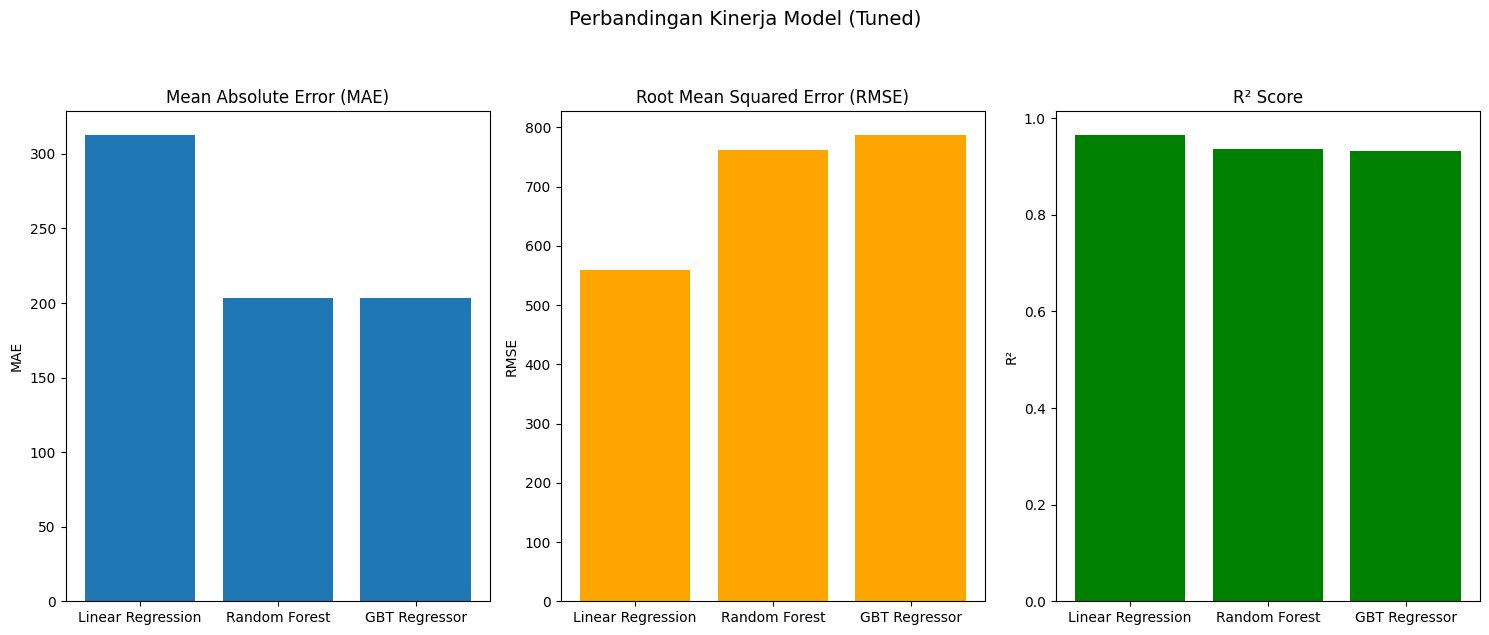

In [176]:
# --- Visualisasi metrik ---
metrics_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'GBT Regressor'],
    'MAE': [mae_lr, mae_rf, mae_gbt],
    'RMSE': [rmse_lr, rmse_rf, rmse_gbt],
    'R2': [r2_lr, r2_rf, r2_gbt]
})

fig, axes = plt.subplots(1, 3, figsize=(15, 6))

axes[0].bar(metrics_df["Model"], metrics_df["MAE"])
axes[0].set_title("Mean Absolute Error (MAE)")
axes[0].set_ylabel("MAE")

axes[1].bar(metrics_df["Model"], metrics_df["RMSE"], color='orange')
axes[1].set_title("Root Mean Squared Error (RMSE)")
axes[1].set_ylabel("RMSE")

axes[2].bar(metrics_df["Model"], metrics_df["R2"], color='green')
axes[2].set_title("R² Score")
axes[2].set_ylabel("R²")

plt.suptitle("Perbandingan Kinerja Model (Tuned)", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

In [177]:
# Cek apakah Spark hidup lagi atau masih dihidup
spark.sparkContext

<SparkContext master=local[*] appName=Midterm Project>

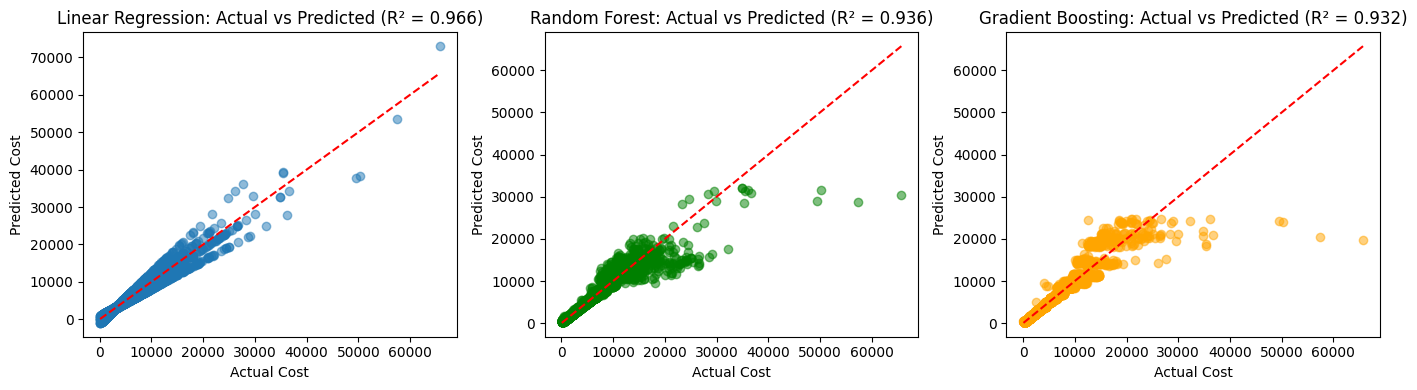

In [186]:
# --- Visualiasasi scatter plot ---
lr_pd = best_lr_predictions.select("annual_medical_cost", "prediction").toPandas()
rf_pd = best_rf_predictions.select("annual_medical_cost", "prediction").toPandas()
gbt_pd = best_gbt_predictions.select("annual_medical_cost", "prediction").toPandas()

# Actual vs Predicted
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].scatter(lr_pd["annual_medical_cost"], lr_pd["prediction"], alpha=0.5)
axes[0].plot([lr_pd["annual_medical_cost"].min(), lr_pd["annual_medical_cost"].max()],
             [lr_pd["annual_medical_cost"].min(), lr_pd["annual_medical_cost"].max()], 'r--')
axes[0].set_title(f'Linear Regression: Actual vs Predicted (R² = {best_lr_r2:.3f})')

axes[1].scatter(rf_pd["annual_medical_cost"], rf_pd["prediction"], alpha=0.5, color="green")
axes[1].plot([rf_pd["annual_medical_cost"].min(), rf_pd["annual_medical_cost"].max()],
             [rf_pd["annual_medical_cost"].min(), rf_pd["annual_medical_cost"].max()], 'r--')
axes[1].set_title(f'Random Forest: Actual vs Predicted (R² = {best_rf_r2:.3f})')

axes[2].scatter(gbt_pd["annual_medical_cost"], gbt_pd["prediction"], alpha=0.5, color="orange")
axes[2].plot([gbt_pd["annual_medical_cost"].min(), gbt_pd["annual_medical_cost"].max()],
             [gbt_pd["annual_medical_cost"].min(), gbt_pd["annual_medical_cost"].max()], 'r--')
axes[2].set_title(f'Gradient Boosting: Actual vs Predicted (R² = {best_gbt_r2:.3f})')

for ax in axes:
    ax.set_xlabel("Actual Cost")
    ax.set_ylabel("Predicted Cost")

plt.tight_layout()
plt.show()

In [179]:
# Cek apakah Spark hidup lagi atau masih dihidup
spark.sparkContext

<SparkContext master=local[*] appName=Midterm Project>

In [181]:
# Buat direktori jika belum ada
os.makedirs("../models", exist_ok=True)

# Simpan model ke direktori models
lr_model.write().overwrite().save("../models/linear_regression_model")
rf_model.write().overwrite().save("../models/random_forest_model")
gbt_model.write().overwrite().save("../models/gbt_model")

best_lr_model.write().overwrite().save("../models/best_linear_regression_model")
best_rf_model.write().overwrite().save("../models/best_random_forest_model")
best_gbt_model.write().overwrite().save("../models/best_gbt_model")

print("Semua model telah disimpan ke folder '../models/'")

Semua model telah disimpan ke folder '../models/'
